In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.dates as mdates

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

# Tratamiento de archivos
# ===============================================================================
import feather
import datetime as dt

# Base de datos 
# ===============================================================================
import pandas as pd 
import  pyodbc

# Modelos estadisticos de anomalias:
# ========================================================================================================================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#------------------------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Nos conectamos a la base de datos y generamos un archivo feather:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=dbtstanalytics.database.windows.net;DATABASE=tstanalytics;UID=analyticsreader;PWD=@q$eQX89Xp7yUEm')
cursor = conn.cursor() 
# Creamos la consulta:
df = pd.read_sql_query('SELECT * FROM Output_EstadoDeResultados', conn ) 
# De dataframe pasamos a formato feather:
df.to_feather('df.feather')
Dtos=pd.read_feather('df.feather')
Dtos.head(3)

,NroAsto,Fecha,EmpresaCod,EmpresaNombre,Monto,NroComp,ComprobanteTipo,CuentaNro,CuentaNombre,Leyenda,...,CodNegocio,IdProy,IdCli,Cliente,Uneg,Fimp,Clase,IdLider,IdCoord,IdResp
0,4323,2021-02-27,1,INTEROPTICS S.A.,-289.25,9,FMC,4210209,OTROS OPERATIVOS,FILIPPONE JOSE MARIA NR,...,TTA19-001,29,1051,TELXIUS TORRES ARGENTINA S.A,MMTO,2021-02-27,POS,97,97,97
1,8132,2021-02-28,2,PRUEBA,-117642.11,20210228,AJD,4210213,COSTO HORAS HOMBRE REASIGNADAS,Asto. Horas x Centro de Costo,...,TTA19-001,29,1051,TELXIUS TORRES ARGENTINA S.A,MMTO,2021-02-28,POS,97,97,97
2,8132,2021-02-28,2,PRUEBA,-1036879.34,20210228,AJD,4210213,COSTO HORAS HOMBRE REASIGNADAS,Asto. Horas x Centro de Costo,...,CIE21-008,4,35,CIENA COMMUNICATIONS INC,MMTO,2021-04-30,FAC,96,96,96


In [7]:
# Mostramos todas las columnas que posee nuestra base de datos, para identificarlas:
Dtos.columns

Index(['NroAsto', 'Fecha', 'EmpresaCod', 'EmpresaNombre', 'Monto', 'NroComp',
       'ComprobanteTipo', 'CuentaNro', 'CuentaNombre', 'Leyenda', 'TipoMov',
       'ObraNro', 'ObraNombre', 'CodNegocio', 'IdProy', 'IdCli', 'Cliente',
       'Uneg', 'Fimp', 'Clase', 'IdLider', 'IdCoord', 'IdResp'],
      dtype='object')

## Clustering: K-Means

In [8]:
# Filtramos el Dataframe que queremos realizar
Dtos_1 = Dtos[['Monto', 'ObraNro', 'TipoMov']]
Dtos_1.head(2)

,Monto,ObraNro,TipoMov
0,-289.25,243881,GTO
1,-117642.11,243881,GTO


### Regla del codo, valor k:

In [9]:
### Utilizamos la regla del "codo" para identificar el valor de K.

# Excluir la columna "TipoMov" antes de la estandarización
columnas_numericas = ['ObraNro', 'Monto']
Dtos_numericos = Dtos_1[columnas_numericas]
Dtos_numericos.head(2)

,ObraNro,Monto
0,243881,-289.25
1,243881,-117642.11


[Código que se tuvo en cuenta para la realización de K-means con Scikit-Learn](https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c)

In [12]:
# Verificamos que esten a la misma escala y tipo de valor
escalado = StandardScaler() # Guardamos la clase estandador escalar de la libreria scikit-learn  // 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

X = escalado.fit_transform(Dtos_numericos) #Fit_Transform devuelve una matriz estandarizada

array([[-0.76293849, -0.02950944],
       [-0.76293849, -0.12579739],
       [-0.76183812, -0.88003099],
       ...,
       [ 0.37374469, -0.02399486],
       [ 0.37374469, -0.02655713],
       [ 0.37374469,  0.02728242]])

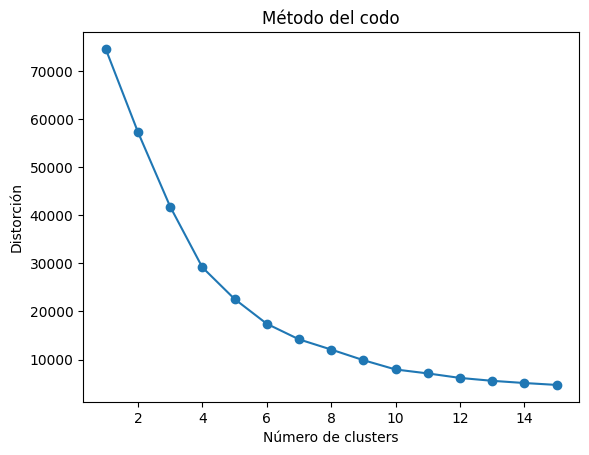

In [106]:
# Medida de como se distribuyen los puntos en los centroides:
# Valor de k en donde la agrupacion de los conglomerados comienzan a disminuir.
Distorcion = []

# Iteramos sobre diferente valores de k:
for k in range(1, 16):
   # Se crea un modelo K-means, con la clase K-means que ofrece scikit-learn
   kmeans = KMeans(n_clusters=k, random_state=42).fit(X) #Modelo se ajusta a datos estandarizados usando fit()
   Distorcion.append(kmeans.inertia_) #Se agregan los valores a la lista

# El grafico es en base a la inercia/ valores de k:
plt.plot(range(1, 16), Distorcion, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters') # Valor k
plt.ylabel('Distorción') #Valores cercanos al cluster
plt.show()

- Podriamos tomar k = 5 o k = 6.

In [108]:
### Generamos un nuevo dataframe uniendo las ventas/gastos y obras:

# Filtrar los datos por tipo de movimiento
gastos = Dtos_1[Dtos_1['TipoMov'] == 'GTO']
ventas = Dtos_1[Dtos_1['TipoMov'] == 'VTA']
activos = Dtos_1[Dtos_1['TipoMov'] == 'ACT']

# Crear el nuevo DataFrame con las columnas correspondientes
df_cluster = pd.DataFrame()
df_cluster['GTO'] = gastos.groupby('ObraNro')['Monto'].sum()
df_cluster['VTA'] = ventas.groupby('ObraNro')['Monto'].sum()
df_cluster['ACT'] = activos.groupby('ObraNro')['Monto'].sum()

# Mostrar el nuevo DataFrame
df_cluster.head(3)

,GTO,VTA,ACT
ObraNro,,,
227977,-2986.36,NaN,NaN
230858,-122081.79,2881427.0,NaN
231273,-116525.63,2742523.0,NaN


### Graficos interactivos:
[Libreria Plotly](https://plotly.com/python/)

In [112]:
# Se puede usar 'import plotly.graph_objects as go' como 'import plotly.express as px',
# Lo que difiere es la personalización que quieras darle al grafico.

import plotly.graph_objects as go

# Crear el gráfico de dispersión
fig = go.Figure(data=go.Scatter( #Creamos un objeto scatter // nueva figura 
    x=df_cluster['VTA'],  
    y=df_cluster['GTO'],  
    mode='markers', # Cada punto se coloca como marcador
    text=df_cluster.index,  # Para cada punto se toma de indice del dataframe
    marker=dict( #Configuracion de tamano y color de los marcadores
        size=10,
        color='blue'
    )
))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Relación entre Ventas y Gastos',
    xaxis_title='Ventas',
    yaxis_title='Gastos',
    hovermode='closest'
)

# Mostrar el gráfico
fig.show()


In [121]:
import plotly.express as px

fig = px.scatter(df_cluster, x='VTA', y='GTO', text=df_cluster.index)

# Tuvimos que usar update_traces por que el parametro marker no es compatible con express
fig.update_traces( # Se usa si o si con la extensión graph_objects
    marker=dict(size=10, color='red', symbol='circle'),  # Tamaño, color y símbolo del marcador
    mode='markers'  
)

fig.update_layout(
    title='Relación entre Ventas y Gastos',
    xaxis_title='Ventas',
    yaxis_title='Gastos',
    hovermode='closest'
)

fig.show()

In [133]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Imputar los valores faltantes en el DataFrame // Si se imputan muchos datos la tendencia central de los datos puede 
# variar: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
imputer = SimpleImputer(strategy='mean') #La media tenemos en cuenta como estrategia
nuevo_df_imputed = imputer.fit_transform(df_cluster[['VTA', 'GTO']])

# Crear el gráfico de dispersión
fig = go.Figure(data=go.Scatter(
    x=nuevo_df_imputed[:, 0],  # Columna de ventas imputada en el eje x
    y=nuevo_df_imputed[:, 1],  # Columna de gastos imputada en el eje y
    mode='markers',
    text=df_cluster.index,  # Columna de número de obra como texto al pasar el mouse sobre los puntos
    marker=dict(
        size=15,
        color='blue'
    )
))

# Aplicar el algoritmo K-means a los datos imputados de ventas y gastos
kmeans = KMeans(n_clusters=6)
kmeans.fit(nuevo_df_imputed)

# Obtenemos etiquetas de los clusters
cluster_labels = kmeans.labels_

# agregamos las etiquetas de los clusters al DataFrame
df_cluster['Cluster'] = cluster_labels

# Configurar los colores de los puntos según los clusters
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow']
marker_colors = [colors[label] for label in cluster_labels]
fig.update_traces(marker=dict(color=marker_colors))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Relación entre Ventas y Gastos (Clustering)',
    xaxis_title='Ventas',
    yaxis_title='Gastos',
    hovermode='closest'
)

# Mostrar el gráfico
fig.show()


In [135]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Imputar los valores faltantes en el DataFrame
imputer = SimpleImputer(strategy='mean')
nuevo_df_imputed = imputer.fit_transform(df_cluster[['VTA', 'GTO']])

# Crear el gráfico de dispersión
fig = go.Figure(data=go.Scatter(
    x=nuevo_df_imputed[:, 0],  # Columna de ventas imputada en el eje x
    y=nuevo_df_imputed[:, 1],  # Columna de gastos imputada en el eje y
    mode='markers',
    text=df_cluster.index,  # Columna de número de obra como texto al pasar el mouse sobre los puntos
    marker=dict(
        size=8,
        color='blue'
    )
))

# Aplicar el algoritmo K-means a los datos imputados de ventas y gastos
kmeans = KMeans(n_clusters=5) #random_state=42
kmeans.fit(nuevo_df_imputed)

# Obtener las etiquetas de los clusters
cluster_labels = kmeans.labels_

# Agregar las etiquetas de los clusters al DataFrame
df_cluster['Cluster'] = cluster_labels

# Obtener los centroides de los clusters
cluster_centers = kmeans.cluster_centers_

# Agregar los centroides al gráfico como puntos rojos
fig.add_trace(go.Scatter(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    mode='markers',
    marker=dict(
        size=10,
        color='red'
    ),
    showlegend=False
))

# Configurar los colores de los puntos según los clusters
colors = ['red', 'green', 'blue', 'orange', 'purple']
marker_colors = [colors[label] for label in cluster_labels]
fig.update_traces(marker=dict(color=marker_colors))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Relación entre Ventas y Gastos (Clustering)',
    xaxis_title='Ventas',
    yaxis_title='Gastos',
    hovermode='closest'
)

# Mostrar el gráfico
fig.show()